In [1]:
# call %matplotlib only in a Jupiter notebook
%matplotlib inline 

# Common and local imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as etree

import cv2
import os
import json

In [2]:
# Create synset to words map of all synsets currently 
# supported in ImageNet
synset_to_word = dict([])

words = open('words.txt','r')

for line in words:
    if line.strip():
        line = line.rstrip().split("\t")
        synsets_str = line[1]
        synsets = [synsets_str]
        if "," in synsets_str:
            synsets = synsets_str.split(",")

        synset_to_word[line[0]] = synsets

words.close() # always close your files.

In [3]:
class ImageAnnotation:
    """
    Example:
        root_dir='/notebooks/dataset/'

        # Annotation dir
        ann_dir = os.path.join(root_dir, 'Annotations', 'DET')
        train_ann = os.path.join(ann_dir, 'train')
        val_ann = os.path.join(ann_dir, 'val')  

        # Data Dir
        data_dir = os.path.join(root_dir, 'Data', 'DET')
        train_data = os.path.join(data_dir, 'train')

        # Helper properties
        train_ann_file_name = 'ILSVRC2014_train_00002439.xml'
        train_ann_file_uri = os.path.join(train_ann, 'ILSVRC2014_train_0000', train_ann_file_name)

        image_annotation = ImageAnnotation(train_ann_file_uri)

        image_annotation.show()
        image_annotation.showAnnotated()
    """
    def __init__(self, annotation_uri):
        # data location
        data_uri = annotation_uri.split("Annotations")
        data_uri = os.path.join((data_uri[0] + "Data"), 
                                (data_uri[1].split(".")[0][1:]))
        
        # Full path to the annotation file
        self.uri = annotation_uri
        
        self.annotation_file_tree = etree.parse(self.uri)
        self.annotation_file_root = self.annotation_file_tree.getroot()
        self.size_node = self.annotation_file_root[3]

        # AnnotationObject properties
        self.location = self.annotation_file_root[0].text
        self.name = self.annotation_file_root[1].text
        self.data_uri = "{}.JPEG".format(data_uri)
        
        self.size = dict([ 
                ("width", int(self.size_node[0].text)), 
                ("height", int(self.size_node[1].text))
        ])
        
        self.objects = []
        
        try: 
            for object_node in self.annotation_file_root[4:]:
                self.objects.append(dict([
                    ("synset", object_node[0].text),
                    ("words", synset_to_word[object_node[0].text]),
                    ("bounding_box", dict([
                        ("xmin", int(object_node[1][0].text)),
                        ("xmax", int(object_node[1][1].text)),
                        ("ymin", int(object_node[1][2].text)),
                        ("ymax", int(object_node[1][3].text))
                    ]))
                ]))
        except IndexError:
            for object_node in self.annotation_file_root[4:]:
                self.objects.append(dict([
                    ("synset", object_node[0].text),
                    ("words", synset_to_word[object_node[0].text]),
                    ("bounding_box", dict([
                        ("xmin", int(object_node[2][0].text)),
                        ("xmax", int(object_node[2][1].text)),
                        ("ymin", int(object_node[2][2].text)),
                        ("ymax", int(object_node[2][3].text))
                    ]))
                ]))
        except:
            print("Could not parse line:\n{}".format(annotation_uri))
            
    def show(self):
        img = cv2.imread(self.data_uri, cv2.IMREAD_UNCHANGED)
        # cv2.imshow(name, img)
        plt.imshow(img)
        plt.show()
        
    def showAnnotated(self, 
                      label_color=[0, 255, 0], # RED 
                      box_color=[255, 0, 0]): # BLUE
        # Copy pristine image
        img_written = cv2.imread(self.data_uri, cv2.IMREAD_UNCHANGED)
        thickness = 4

        for object in self.objects:
            bnd_box = object["bounding_box"]
            top_left = (bnd_box["xmin"], bnd_box["ymax"])
            bottom_right = (bnd_box["xmax"], bnd_box["ymin"])

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_size = 0.6
            font_scale = 2
            label_top_left = (bnd_box["xmin"] + 6, 
                              bnd_box["ymin"] + 18)

            # Draw bounding box
            cv2.rectangle(img_written,
                          top_left,
                          bottom_right,
                          box_color, 
                          thickness)
            # Write object label
            cv2.putText(img_written,
                        object["words"][0],
                        label_top_left,
                        font,
                        font_size,
                        label_color,
                        font_scale,
                        lineType=cv2.LINE_AA)

        # cv2.imshow(name, img)
        plt.imshow(img_written)
        plt.show()
        

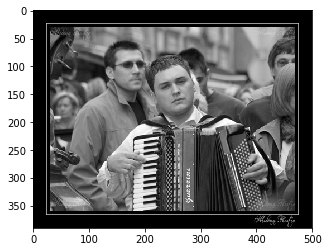

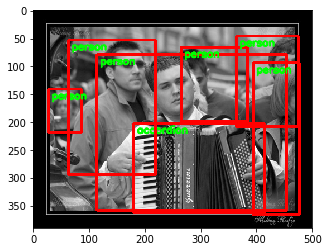

In [4]:
root_dir='/notebooks/dataset/'

# Annotation dir
ann_dir = os.path.join(root_dir, 'Annotations', 'DET')
train_ann = os.path.join(ann_dir, 'train')
val_ann = os.path.join(ann_dir, 'val')  

# Data Dir
data_dir = os.path.join(root_dir, 'Data', 'DET')
train_data = os.path.join(data_dir, 'train')

# Helper properties
train_ann_file_name = 'ILSVRC2014_train_00002439.xml'
train_ann_file_uri = os.path.join(train_ann, 'ILSVRC2014_train_0000', train_ann_file_name)

image_annotation = ImageAnnotation(train_ann_file_uri)

image_annotation.show()
image_annotation.showAnnotated()